# Take home test

## Data exploration and cleaning

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline



Let's load the data for one month, forcing string objects for numerical data that are actually a coding scheme, and parsing datetime fields properly.

In [36]:
data = pd.read_csv("inputdata/yellow_tripdata_2017-03.csv", 
                   dtype={'PULocationID':str, 'DOLocationID':str, 'RatecodeID':str,  'payment_type':str,
                         'VendorID':str})
data['tpep_pickup_datetime']=pd.to_datetime(data['tpep_pickup_datetime'],
                                            format='%Y-%m-%d %H:%M:%S', errors='coerce')
data['tpep_dropoff_datetime']=pd.to_datetime(data['tpep_dropoff_datetime'],
                                            format='%Y-%m-%d %H:%M:%S', errors='coerce')

In [37]:
data.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
0,2,2017-03-09 21:30:11,2017-03-09 21:44:20,1,4.06,1,N,148,48,1,14.0,0.5,0.5,3.06,0.0,0.3,18.36
1,2,2017-03-09 21:47:00,2017-03-09 21:58:01,1,2.73,1,N,48,107,2,11.5,0.5,0.5,0.00,0.0,0.3,12.80
2,2,2017-03-09 22:01:08,2017-03-09 22:11:16,1,2.27,1,N,79,162,1,10.0,0.5,0.5,2.82,0.0,0.3,14.12
3,2,2017-03-09 22:16:05,2017-03-10 06:26:11,1,3.86,1,N,237,41,1,12.0,0.5,0.5,3.99,0.0,0.3,17.29
4,2,2017-03-31 06:31:53,2017-03-31 06:41:48,1,3.45,1,N,41,162,2,12.0,0.5,0.5,0.00,0.0,0.3,13.30


In [38]:
data.describe()

,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
count,1.029463e+07,1.029463e+07,1.029463e+07,1.029463e+07,1.029463e+07,1.029463e+07,1.029463e+07,1.029463e+07,1.029463e+07
mean,1.618225e+00,2.884684e+00,1.291388e+01,3.408597e-01,4.973619e-01,1.857154e+00,3.104581e-01,2.996462e-01,1.622369e+01
std,1.262620e+00,3.720506e+00,5.499035e+01,4.674591e-01,7.189369e-02,2.621220e+00,1.902767e+00,1.386019e-02,5.561842e+01
min,0.000000e+00,0.000000e+00,-3.080000e+02,-5.371000e+01,-5.000000e-01,-9.100000e+01,-1.750000e+01,-3.000000e-01,-3.088000e+02
25%,1.000000e+00,9.400000e-01,6.500000e+00,0.000000e+00,5.000000e-01,0.000000e+00,0.000000e+00,3.000000e-01,8.400000e+00
50%,1.000000e+00,1.600000e+00,9.500000e+00,0.000000e+00,5.000000e-01,1.360000e+00,0.000000e+00,3.000000e-01,1.180000e+01
75%,2.000000e+00,3.000000e+00,1.450000e+01,5.000000e-01,5.000000e-01,2.450000e+00,0.000000e+00,3.000000e-01,1.780000e+01
max,9.000000e+00,5.985000e+02,1.718618e+05,6.980000e+01,1.033000e+02,4.254700e+02,9.235000e+02,5.000000e-01,1.718636e+05


Here we can see what we can expect from the data. If we read the data dictionary we can understand the semantics of some fields which are not intuitive (such as 'RatecodeID' or 'store_and_fwd_flag'). Additionally we can see the format used for instance, in the datetime fields.

We can take a look at means and extremes to gather some hints about the data but also potential issues. For example the 'fare_amount' field is a bit suspicious (percentile 75 is ~ $14.5, but the maximum is in the tens of thousands!). Or we can also see that some money amounts can be negative. We will need to consider at the same time knowledge about the data and analysis techniques.

In [39]:
data.shape

(10294628, 17)

We can also see that we have a very nice set, with about 10 million entries for the month of March.

### Cleaning

There are some basic task we can follow to check the validity of the entries in the data set.

First, find whether we have null (not present) values

In [44]:
null_cols = data.columns[data.isna().any()]

data[null_cols].isna().sum()


Series([], dtype: float64)

We have an empty output, so we didn't find any null (NaN, NaT, etc) value in the data.

Then we can check the semantics of the values. For example, the PickUp datetime must occur before the DropOff (if using localtime then Saving Time issues may appear). RateCode must be between 1 and 6. The distance should be positive greater than zero (and we could optionally try to have a reasonable minimum and maximum). All of these checks come from logic assumptions or the data dictionary.
Also by having more knowledge from some expert (an example for this case, taxi drivers) other checks may be used. Let's assume, for example, that a valid entry must have a number of passengers of at least one.

In [45]:
diff_date=(data['tpep_dropoff_datetime']-data['tpep_pickup_datetime']).astype('timedelta64[s]')

bad_dates=diff_date.index[diff_date < 0].tolist()

Let's check the output:

In [46]:
data.loc[bad_dates]

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
4890789,1,2017-03-14 15:15:22,2017-03-11 15:55:05,1,11.7,1,Y,164,26,1,42.0,1.0,0.5,3.00,5.54,0.3,52.34
7012746,1,2017-03-25 20:21:21,2017-03-25 20:05:27,1,2.2,1,N,229,50,1,15.5,0.0,0.5,3.25,0.00,0.3,19.55


Of course maybe the usage of 'store and forward' as the data production from the taxi could impact these values. Be as it may, we cannot know the cause behind this case, so we shouldn't use at least the timestamps for these entries. For simplicity in this case the 'bad_dates' entries will be ignored, and the same considerations will be used for the rest of the tests:

In [21]:
bad_distance=data.index[data['trip_distance'] <= 0].tolist()
bad_RatecodeID=data.index[~data['RatecodeID'].isin([str(x) for x in range(1,7)])].tolist()
bad_charges=data.index[(data['fare_amount'] < 0) | (data['extra'] < 0) | (data['mta_tax'] < 0) | (data['tip_amount'] < 0) |
                       (data['tolls_amount'] < 0) | (data['improvement_surcharge'] < 0) | (data['total_amount'] < 0)]
bad_entries=set(bad_dates) | set(bad_distance) | set(bad_RatecodeID) | set(bad_charges)

In [22]:
print("Number of ignored entries: %d" % len(bad_entries))
print("Ratio of invalid entries: %f" % (len(bad_entries)/data.shape[0]))

Number of ignored entries: 70422
Ratio of invalid entries: 0.006841


In [23]:
data=data.drop(data.index[list(bad_entries)])

We could imputate some of the data as well in cases where we can make reasonable assumptions. For example, let's locate the cases where the number of passengers is not valid (less than one), and substitute those cases with (for instance) the median value. Although the mean value is faster to calculate given the number of entries.

In [24]:
mean_passenger=np.mean(data['passenger_count'])
data[data['passenger_count']<1] = mean_passenger

## Data summary

We have 17 different fields with different semantics. This could be a basic summary extending the semantics present at http://www.nyc.gov/html/tlc/downloads/pdf/data_dictionary_trip_records_yellow.pdf

| variable | type | comments |
| :--- | --- | ---: |
| **VendorID** | categorical | Provider of the data, note 1 |
| **tpep_pickup_datetime** 	| timestamp string | Pick Up Time in NYC local time |
| **tpep_dropoff_datetime** | timestamp string | Drop Off Time in NYC local time |
| **passenger_count** | integer | Data entered manually (by driver) |
| **trip_distance** | float | Distance in miles as per taximeter |
| **RatecodeID** | categorical | Rate code, note 1 |
| **store_and_fwd_flag**  | categorical | data storage mode |
| **PULocationID** | categorical-spatial | note 1, note 2 |
| **DOLocationID** | categorical-spatial | note 1, note 2 |
| **payment_type**  | categorical | Payment method, and null trip indicator "6", note 1 |
| **fare_amount** | float | The base charge from the taximeter |
| **extra** | float | Extra charges |
| **mta_tax** | float | Tax charges |
| **tip_amount** | float | Automatic card tip, cash tips not included |
| **tolls_amount** | float | Tolls charges |
| **improvement_surcharge** | float | Levied in 2015 |
| **total_amount** | float | Does not include cash tips |


Note 1: Categorical variable represented with a number, care should be taken when importing this data so it is not treated as a number

Note 2: Code refers to a given spatial area, values may be obtained from shapes file. This could be interesting when searching for spatial clusters

It is interesting to note that cash tips are not visible. Let's assume this does not impact the result.

## Some insights with descriptive analysis

### Trip distance distribution and outliers

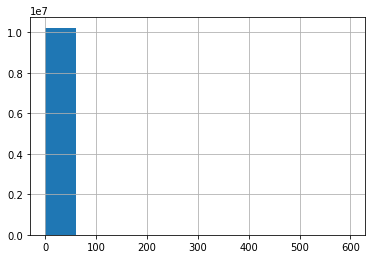

In [25]:
hist=data['trip_distance'].hist()

This result is strange. Not because it is more likely to have lower distance trips, but the huge difference between the extremes. Let's see a box plot:

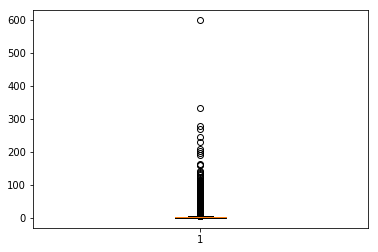

In [26]:
plt.boxplot(data['trip_distance'])
plt.show()

Now this figure is interesting. We can see we have many supposed outliers as per a standard box plot. Nevertheless in this case our distribution looks more concentrated towards lower values. Let's see when we visualise the samples through a non-linear function:

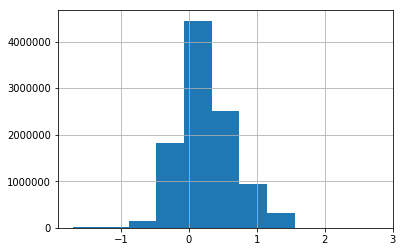

In [27]:
hist=np.log10(0.01+data['trip_distance']).hist(bins=11)

Not clear yet what is the best model fit for this data (maybe log-normal?). Intuitively it seems that anything below 160m (one tenth of a mile) or over 50Km (1 mile times 10^1.5) can be considered rare. More rigurously, 99% of samples fall between:

In [28]:
np.percentile(data['trip_distance'], [0.5, 99.5])


array([ 0.2, 20.6])

We may decide that we prefer a model based on reasonable assumptions and filter out anything beyond these bounds, or maybe we do want to keep the outliers, so we may have an example of an extreme case. Alhtough being outliers there will not be many, and maybe not representative. As always, the tradeoff between good generalisations and behaviour in extreme cases (such as long-tail models) will need to be considered up to the last mile, and a good test set should be used to have a good insight.

But the identification of outliers admits different perspectives, even more when we deal with time series (for example using MUOD https://www.nature.com/articles/s41598-018-24874-2)

### Most frequent locations

We can see where the pick-ups are more likely:

In [113]:
locations_group = data['PULocationID'].value_counts()


Text(0,0.5,'Occurrences')

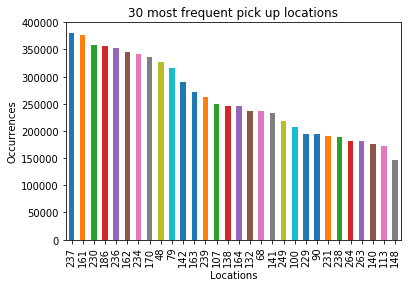

In [117]:
plot_locations=locations_group.head(30).plot(kind='bar', legend=None, title="30 most frequent pick up locations")
plot_locations.set_xlabel("Locations")
plot_locations.set_ylabel("Occurrences")

### Time/space trends

We could also try to have a more complex descriptive analysis from the data, trying to solve some questions such as where it could be the most profitable given the time of the day. Let's assume (at least from my humble perspective) that the profitability is proportional to the ratio of tip amount over distance, and make some viz for the 30 most frequent locations. This is a decision with very little basis, as we don't know yet what the best location should be, and by no means being the most likely should be regarded a guarantee of profitability. But with this artificial limitation calculations are fast to show what types of processing we can do with data. And also, if the new company is to try to take a piece of the cake, it is a better scenario if the cake is big for everyone.

In [139]:
data['tip_per_distance']=data['tip_amount']/(0.1+data['trip_distance']) # Just in case
hm_data=data[ ['tip_per_distance', 'PULocationID', 'tpep_pickup_datetime']]
hm_data=hm_data[hm_data['PULocationID'].isin(locations_group.head(30).index)]


In [140]:
hm_data['hour_week']=hm_data['tpep_pickup_datetime'].dt.hour+hm_data['tpep_pickup_datetime'].dt.dayofweek*24

In [141]:
hm_grouping = hm_data.groupby(['PULocationID', 'hour_week'])

With this we have a reference of what is the best area to cover with the taxi given the time and day of the week:

In [155]:
heatmap_values=hm_grouping['tip_per_distance'].mean()


Also we could try to see this data on a 2D figure, although it is not a good viz (too many indexes). The grid will show the profitability index on a grid of zones by hour of the week. I will use a compressing function to make it easy to the eye to spot differences.

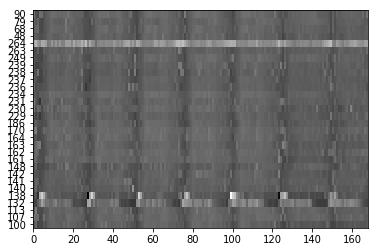

In [154]:
heatmap_values=heatmap.unstack(fill_value=0)

plt.pcolor(np.log10(0.1+heatmap_values), cmap='gray')
plt.yticks(np.arange(0.5, len(heatmap_values.index), 1), heatmap_values.index)
plt.show()

At least we can appreciate how some locations have consistently better profitability (264), as well as different hours through the day (see 138 and 132). We can also see that time trends can be different for different locations as well, so we should take this into account if we are to make time series analysis by not aggregating different locations.

Nevertheless this approach is a bit naïve, as there are other factors that may impact, such as longer travels might be better than short ones (more efficient), we have aggregated data with no regard to special events, limited search space, etc. Additionally we would need a strategy generator to select which area or areas to go, which can also depend on where and when we are already present, and so on. But I think such considerations are out of the scope of this test.

Also, this visualisation may be more practical in a map form. As zones identifiers are assigned alphabetically the figure above does not show correctly the spatial relations between the zones which could be exploited as well. Now that we have some blind results from the analysis let's solve for the true locations and see if it makes some sense:

In [157]:
zones=pd.read_csv("inputdata/taxi _zone_lookup.csv", dtype={'LocationID':str})

enriched_best = pd.merge(heatmap_values.reset_index(), zones, left_on='PULocationID', right_on='LocationID')



In [161]:
enriched_best.sort_values(by='tip_per_distance', ascending=False).head(30)

,PULocationID,hour_week,tip_per_distance,LocationID,Borough,Zone,service_zone
771,138,99,40.300000,138,Queens,LaGuardia Airport,Airports
701,138,29,14.176462,138,Queens,LaGuardia Airport,Airports
725,138,53,13.840028,138,Queens,LaGuardia Airport,Airports
676,138,4,12.860774,138,Queens,LaGuardia Airport,Airports
772,138,100,12.250356,138,Queens,LaGuardia Airport,Airports
749,138,77,9.876945,138,Queens,LaGuardia Airport,Airports
798,138,126,9.249734,138,Queens,LaGuardia Airport,Airports
4349,264,149,8.881906,264,Unknown,NV,NaN
4275,264,75,8.848309,264,Unknown,NV,NaN
773,138,101,8.279487,138,Queens,LaGuardia Airport,Airports


We can see that going to airports to pick up passengers can be very profitable. That, if does not make sense, at least is seen as common practice among taxi drivers in many places.

It is also interesting to see that some of the most profitable pickup locations are marked as Unknown as per the zone dictionary! 